In [1]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.auto import tqdm
import os
from nltk.translate.bleu_score import sentence_bleu
import nltk
from sacremoses import MosesTokenizer, MosesDetokenizer
from collections import defaultdict
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import gc
from collections import Counter

# Download required NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

C:\Users\urjap\anaconda3\envs\env\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
C:\Users\urjap\anaconda3\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\urjap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\urjap\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Cell 2: Define SanskritEnglishDataset class
class SanskritEnglishDataset(Dataset):
    def __init__(self, data, sanskrit_vocab, english_vocab, max_length=64):
        self.data = data
        self.sanskrit_vocab = sanskrit_vocab
        self.english_vocab = english_vocab
        self.max_length = max_length
        self.sanskrit_tokenizer = MosesTokenizer(lang='sa')
        self.english_tokenizer = MosesTokenizer(lang='en')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        sanskrit = item['content']
        english = item['explanation']

        sanskrit_tokens = self.sanskrit_tokenizer.tokenize(sanskrit)
        english_tokens = self.english_tokenizer.tokenize(english)

        sanskrit_indices = [self.sanskrit_vocab.get(token, self.sanskrit_vocab['<UNK>']) for token in sanskrit_tokens]
        english_indices = [self.english_vocab.get(token, self.english_vocab['<UNK>']) for token in english_tokens]

        sanskrit_indices = sanskrit_indices[:self.max_length] + [0] * (self.max_length - len(sanskrit_indices))
        english_indices = [self.english_vocab['<START>']] + english_indices + [self.english_vocab['<END>']]
        english_indices = english_indices[:self.max_length] + [0] * (self.max_length - len(english_indices))

        return {
            'sanskrit': torch.tensor(sanskrit_indices),
            'english': torch.tensor(english_indices),
            'english_input': torch.tensor(english_indices[:-1]),
            'english_output': torch.tensor(english_indices[1:])
        }

In [3]:
# Cell 4: Define the evaluate_translation function
def evaluate_translation(reference, hypothesis):
    """Calculate BLEU score and other metrics"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens)

    overlap = len(set(reference_tokens) & set(hypothesis_tokens))
    total = len(set(reference_tokens) | set(hypothesis_tokens))
    overlap_score = overlap / total if total > 0 else 0

    return {
        'bleu': bleu_score,
        'word_overlap': overlap_score
    }

In [4]:
# Cell 5: Load Data and Build Vocabulary
df = pd.read_csv("sundarakanda.csv")

print("Building vocabularies...")
sanskrit_tokenizer = MosesTokenizer(lang='sa')
english_tokenizer = MosesTokenizer(lang='en')

sanskrit_counter = Counter()
english_counter = Counter()

for index, row in tqdm(df.iterrows(), total=len(df)):
    sanskrit_tokens = sanskrit_tokenizer.tokenize(row['content'])
    english_tokens = english_tokenizer.tokenize(row['explanation'])
    sanskrit_counter.update(sanskrit_tokens)
    english_counter.update(english_tokens)

sanskrit_vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}
english_vocab = {'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3}

for token, _ in sanskrit_counter.most_common(10000):
    sanskrit_vocab[token] = len(sanskrit_vocab)

for token, _ in english_counter.most_common(10000):
    english_vocab[token] = len(english_vocab)

print("Vocabulary building complete.")

Building vocabularies...


100%|█████████████████████████████████████████████████████████████████████████████| 2535/2535 [00:02<00:00, 985.97it/s]


Vocabulary building complete.


In [5]:
# Cell 3: Define SanskritNMT class
class SanskritNMT(nn.Module):
    def __init__(self, sanskrit_vocab_size, english_vocab_size, embedding_dim=256, hidden_dim=512):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.sanskrit_embedding = nn.Embedding(sanskrit_vocab_size, embedding_dim)
        self.english_embedding = nn.Embedding(english_vocab_size, embedding_dim)

        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim * 2, num_layers=2, batch_first=True)

        self.output_layer = nn.Linear(hidden_dim * 2, english_vocab_size)

        self.to(self.device)

    def forward(self, sanskrit, english_input):
        sanskrit_embedded = self.sanskrit_embedding(sanskrit)
        english_embedded = self.english_embedding(english_input)

        encoder_outputs, (hidden, cell) = self.encoder(sanskrit_embedded)

        hidden = hidden.view(2, 2, -1, hidden.size(2))
        hidden = hidden.permute(1, 0, 2, 3).contiguous().view(2, -1, hidden.size(3) * 2)
        cell = cell.view(2, 2, -1, cell.size(2))
        cell = cell.permute(1, 0, 2, 3).contiguous().view(2, -1, cell.size(3) * 2)

        decoder_outputs, _ = self.decoder(english_embedded, (hidden, cell))

        output = self.output_layer(decoder_outputs)

        return output

    def translate(self, sanskrit_text, sanskrit_vocab, english_vocab, max_length=64):
        self.eval()
        sanskrit_tokenizer = MosesTokenizer(lang='sa')
        english_detokenizer = MosesDetokenizer(lang='en')

        sanskrit_tokens = sanskrit_tokenizer.tokenize(sanskrit_text)
        sanskrit_indices = [sanskrit_vocab.get(token, sanskrit_vocab['<UNK>']) for token in sanskrit_tokens]

        sanskrit_indices = sanskrit_indices[:max_length] + [0] * (max_length - len(sanskrit_indices))

        sanskrit_tensor = torch.tensor([sanskrit_indices]).to(self.device)

        with torch.no_grad():
            sanskrit_embedded = self.sanskrit_embedding(sanskrit_tensor)

            encoder_outputs, (hidden, cell) = self.encoder(sanskrit_embedded)

            hidden = hidden.view(2, 2, -1, hidden.size(2))
            hidden = hidden.permute(1, 0, 2, 3).contiguous().view(2, -1, hidden.size(3) * 2)
            cell = cell.view(2, 2, -1, cell.size(2))
            cell = cell.permute(1, 0, 2, 3).contiguous().view(2, -1, cell.size(3) * 2)

            decoder_input = torch.tensor([[english_vocab['<START>']]]).to(self.device)
            translated_indices = []

            for _ in range(max_length):
                decoder_embedded = self.english_embedding(decoder_input)
                decoder_outputs, (hidden, cell) = self.decoder(decoder_embedded, (hidden, cell))
                output = self.output_layer(decoder_outputs[:, -1])

                next_token = output.argmax(dim=1)
                translated_indices.append(next_token.item())

                if next_token.item() == english_vocab['<END>']:
                    break

                decoder_input = next_token.unsqueeze(0)

        translated_tokens = []
        for idx in translated_indices:
            if idx in english_vocab.values():
                token = list(english_vocab.keys())[list(english_vocab.values()).index(idx)]
                if token not in ['<START>', '<END>', '<PAD>', '<UNK>']:
                    translated_tokens.append(token)

        return english_detokenizer.detokenize(translated_tokens)

In [6]:
# Cell 1: Training NMT (Epochs=1)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

gc.collect()
torch.cuda.empty_cache()

nmt_model_1 = SanskritNMT(len(sanskrit_vocab), len(english_vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nmt_model_1.to(device)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

nmt_dataset = SanskritEnglishDataset(train_df, sanskrit_vocab, english_vocab)
batch_size = 16
train_loader = DataLoader(nmt_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(nmt_model_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 1

print("\nTraining NMT model (Epochs=1)...")
for epoch in range(num_epochs):
    nmt_model_1.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        sanskrit = batch['sanskrit'].to(nmt_model_1.device)
        english_input = batch['english_input'].to(nmt_model_1.device)
        english_output = batch['english_output'].to(nmt_model_1.device)
        output = nmt_model_1(sanskrit, english_input)
        output = output.reshape(-1, output.size(-1))
        target = english_output.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del output, loss
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
print("NMT training complete (Epochs=1).")


Training NMT model (Epochs=1)...


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:29<00:00,  2.59s/it]

Epoch 1/1, Average Loss: 6.1633
NMT training complete (Epochs=1).


In [7]:
# Cell 2: Training NMT (Epochs=2)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split

gc.collect()
torch.cuda.empty_cache()

nmt_model_2 = SanskritNMT(len(sanskrit_vocab), len(english_vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nmt_model_2.to(device)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

nmt_dataset = SanskritEnglishDataset(train_df, sanskrit_vocab, english_vocab)
batch_size = 16
train_loader = DataLoader(nmt_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(nmt_model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 2

print("\nTraining NMT model (Epochs=2)...")
for epoch in range(num_epochs):
    nmt_model_2.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        sanskrit = batch['sanskrit'].to(nmt_model_2.device)
        english_input = batch['english_input'].to(nmt_model_2.device)
        english_output = batch['english_output'].to(nmt_model_2.device)
        output = nmt_model_2(sanskrit, english_input)
        output = output.reshape(-1, output.size(-1))
        target = english_output.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del output, loss
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
print("NMT training complete (Epochs=2).")


Training NMT model (Epochs=2)...


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:38<00:00,  2.66s/it]


Epoch 1/2, Average Loss: 6.1799


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:39<00:00,  2.68s/it]

Epoch 2/2, Average Loss: 5.3445
NMT training complete (Epochs=2).


In [8]:
# Cell 3: Training NMT (Epochs=5)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split

gc.collect()
torch.cuda.empty_cache()

nmt_model_5 = SanskritNMT(len(sanskrit_vocab), len(english_vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nmt_model_5.to(device)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

nmt_dataset = SanskritEnglishDataset(train_df, sanskrit_vocab, english_vocab)
batch_size = 16
train_loader = DataLoader(nmt_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(nmt_model_5.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 5

print("\nTraining NMT model (Epochs=5)...")
for epoch in range(num_epochs):
    nmt_model_5.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        sanskrit = batch['sanskrit'].to(nmt_model_5.device)
        english_input = batch['english_input'].to(nmt_model_5.device)
        english_output = batch['english_output'].to(nmt_model_5.device)
        output = nmt_model_5(sanskrit, english_input)
        output = output.reshape(-1, output.size(-1))
        target = english_output.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del output, loss
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
print("NMT training complete (Epochs=5).")



Training NMT model (Epochs=5)...


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:34<00:00,  2.63s/it]


Epoch 1/5, Average Loss: 6.2026


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:34<00:00,  2.63s/it]


Epoch 2/5, Average Loss: 5.3708


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:34<00:00,  2.64s/it]


Epoch 3/5, Average Loss: 4.8835


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:34<00:00,  2.63s/it]


Epoch 4/5, Average Loss: 4.4624


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:33<00:00,  2.63s/it]

Epoch 5/5, Average Loss: 4.0398
NMT training complete (Epochs=5).


In [9]:
# Cell 4: Training NMT (Epochs=10)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split

gc.collect()
torch.cuda.empty_cache()

nmt_model_10 = SanskritNMT(len(sanskrit_vocab), len(english_vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nmt_model_10.to(device)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

nmt_dataset = SanskritEnglishDataset(train_df, sanskrit_vocab, english_vocab)
batch_size = 16
train_loader = DataLoader(nmt_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(nmt_model_10.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 10

print("\nTraining NMT model (Epochs=10)...")
for epoch in range(num_epochs):
    nmt_model_10.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        sanskrit = batch['sanskrit'].to(nmt_model_10.device)
        english_input = batch['english_input'].to(nmt_model_10.device)
        english_output = batch['english_output'].to(nmt_model_10.device)
        output = nmt_model_10(sanskrit, english_input)
        output = output.reshape(-1, output.size(-1))
        target = english_output.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del output, loss
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
    print("NMT training complete (Epochs=10).")


Training NMT model (Epochs=10)...


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:39<00:00,  2.68s/it]


Epoch 1/10, Average Loss: 6.1693
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:37<00:00,  2.66s/it]


Epoch 2/10, Average Loss: 5.3400
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:39<00:00,  2.68s/it]


Epoch 3/10, Average Loss: 4.8795
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:40<00:00,  2.68s/it]


Epoch 4/10, Average Loss: 4.4690
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:40<00:00,  2.68s/it]


Epoch 5/10, Average Loss: 4.0548
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:38<00:00,  2.66s/it]


Epoch 6/10, Average Loss: 3.5984
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:39<00:00,  2.67s/it]


Epoch 7/10, Average Loss: 3.0924
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:36<00:00,  2.65s/it]


Epoch 8/10, Average Loss: 2.5251
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:40<00:00,  2.68s/it]


Epoch 9/10, Average Loss: 1.9633
NMT training complete (Epochs=10).


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:15<00:00,  2.49s/it]

Epoch 10/10, Average Loss: 1.4407
NMT training complete (Epochs=10).


In [10]:
# Cell 5: Training NMT (Epochs=15)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split

gc.collect()
torch.cuda.empty_cache()

nmt_model_15 = SanskritNMT(len(sanskrit_vocab), len(english_vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nmt_model_15.to(device)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

nmt_dataset = SanskritEnglishDataset(train_df, sanskrit_vocab, english_vocab)
batch_size = 16
train_loader = DataLoader(nmt_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(nmt_model_15.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 15

print("\nTraining NMT model (Epochs=15)...")
for epoch in range(num_epochs):
    nmt_model_15.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        sanskrit = batch['sanskrit'].to(nmt_model_15.device)
        english_input = batch['english_input'].to(nmt_model_15.device)
        english_output = batch['english_output'].to(nmt_model_15.device)
        output = nmt_model_15(sanskrit, english_input)
        output = output.reshape(-1, output.size(-1))
        target = english_output.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        del output, loss
        torch.cuda.empty_cache()
        gc.collect()
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
print("NMT training complete (Epochs=15).")



Training NMT model (Epochs=15)...


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:14<00:00,  2.47s/it]


Epoch 1/15, Average Loss: 6.1675


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:14<00:00,  2.48s/it]


Epoch 2/15, Average Loss: 5.3124


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:14<00:00,  2.48s/it]


Epoch 3/15, Average Loss: 4.8305


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:14<00:00,  2.47s/it]


Epoch 4/15, Average Loss: 4.3880


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:13<00:00,  2.47s/it]


Epoch 5/15, Average Loss: 3.9402


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:09<00:00,  2.43s/it]


Epoch 6/15, Average Loss: 3.4292


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:24<00:00,  2.55s/it]


Epoch 7/15, Average Loss: 2.8649


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:25<00:00,  2.56s/it]


Epoch 8/15, Average Loss: 2.2815


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:25<00:00,  2.57s/it]


Epoch 9/15, Average Loss: 1.7179


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:26<00:00,  2.57s/it]


Epoch 10/15, Average Loss: 1.2232


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:27<00:00,  2.58s/it]


Epoch 11/15, Average Loss: 0.8472


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:27<00:00,  2.58s/it]


Epoch 12/15, Average Loss: 0.5850


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:27<00:00,  2.58s/it]


Epoch 13/15, Average Loss: 0.4430


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:28<00:00,  2.58s/it]


Epoch 14/15, Average Loss: 0.3756


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [05:27<00:00,  2.58s/it]

Epoch 15/15, Average Loss: 0.3460
NMT training complete (Epochs=15).



Evaluating model trained with 1 epochs...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [05:09<00:00,  1.64it/s]


Evaluation of Epoch 1:
  Average BLEU score: 0.0144
  Average Word Overlap score: 0.0998

Evaluating model trained with 2 epochs...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [08:14<00:00,  1.03it/s]


Evaluation of Epoch 2:
  Average BLEU score: 0.0087
  Average Word Overlap score: 0.0717

Evaluating model trained with 5 epochs...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [04:21<00:00,  1.94it/s]


Evaluation of Epoch 5:
  Average BLEU score: 0.0224
  Average Word Overlap score: 0.1282

Evaluating model trained with 10 epochs...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [03:28<00:00,  2.43it/s]


Evaluation of Epoch 10:
  Average BLEU score: 0.0162
  Average Word Overlap score: 0.1144

Evaluating model trained with 15 epochs...


100%|████████████████████████████████████████████████████████████████████████████████| 507/507 [04:10<00:00,  2.02it/s]


Evaluation of Epoch 15:
  Average BLEU score: 0.0147
  Average Word Overlap score: 0.0936


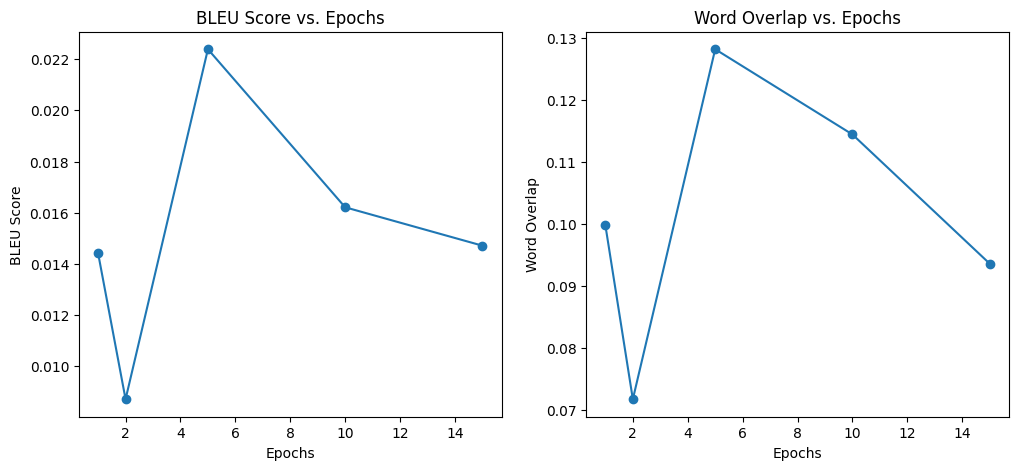

In [13]:
# Cell 6: Evaluation and Graphing
def evaluate_translation(reference, hypothesis):
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())
    smoothie = SmoothingFunction().method4
    bleu_score_nmt = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothie)
    overlap = len(set(reference_tokens) & set(hypothesis_tokens))
    total = len(set(reference_tokens) | set(hypothesis_tokens))
    overlap_score_nmt = overlap / total if total > 0 else 0
    return {'bleu': bleu_score_nmt, 'word_overlap': overlap_score_nmt}

def evaluate_model(model, test_df, sanskrit_vocab, english_vocab, epoch_num):
    print(f"\nEvaluating model trained with {epoch_num} epochs...") # Added print statement here
    bleu_scores_nmt = []
    overlap_scores_nmt = []
    for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
        reference = str(row['explanation'])
        hypothesis = model.translate(row['content'], sanskrit_vocab, english_vocab)
        evaluation_results = evaluate_translation(reference, hypothesis)
        bleu_scores_nmt.append(evaluation_results['bleu'])
        overlap_scores_nmt.append(evaluation_results['word_overlap'])
    avg_bleu = np.mean(bleu_scores_nmt)
    avg_overlap = np.mean(overlap_scores_nmt)
    print(f"Evaluation of Epoch {epoch_num}:")
    print(f"  Average BLEU score: {avg_bleu:.4f}")
    print(f"  Average Word Overlap score: {avg_overlap:.4f}")
    return avg_bleu, avg_overlap

bleu_1, overlap_1 = evaluate_model(nmt_model_1, test_df, sanskrit_vocab, english_vocab, 1)
bleu_2, overlap_2 = evaluate_model(nmt_model_2, test_df, sanskrit_vocab, english_vocab, 2)
bleu_5, overlap_5 = evaluate_model(nmt_model_5, test_df, sanskrit_vocab, english_vocab, 5)
bleu_10, overlap_10 = evaluate_model(nmt_model_10, test_df, sanskrit_vocab, english_vocab, 10)
bleu_15, overlap_15 = evaluate_model(nmt_model_15, test_df, sanskrit_vocab, english_vocab, 15)

epochs = [1, 2, 5, 10, 15]
bleu_scores = [bleu_1, bleu_2, bleu_5, bleu_10, bleu_15]
overlap_scores = [overlap_1, overlap_2, overlap_5, overlap_10, overlap_15]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, bleu_scores, marker='o')
plt.title("BLEU Score vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.subplot(1, 2, 2)
plt.plot(epochs, overlap_scores, marker='o')
plt.title("Word Overlap vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Word Overlap")
plt.show()